In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io as scio 
import scipy.io as sio  
import math
import scipy
from tensorflow.python.framework import ops 
from scipy.sparse import csr_matrix 
from sklearn.model_selection import train_test_split
tf.compat.v1.disable_eager_execution()

In [2]:
def split_data(cuprite_data, cnn_data, labels):
    # Get the number of spectral bands for the cuprite data
    num_spectral_bands_cuprite = cuprite_data.shape[1]
    
    # Reshape the CNN data to have the same number of spectral bands as the cuprite data
    cnn_data = cnn_data.reshape((cnn_data.shape[0], num_spectral_bands_cuprite, 7, 7))
    
    # Split the data into training and testing sets
    cuprite_train, cuprite_test, cnn_train, cnn_test, labels_train, labels_test = train_test_split(
        cuprite_data, cnn_data, labels, test_size=0.2, random_state=42
    )
    
    # Reshape the CNN data back to its original shape
    cnn_train = cnn_train.reshape((cnn_train.shape[0], cnn_train.shape[1]*cnn_train.shape[2]*cnn_train.shape[3]))
    cnn_test = cnn_test.reshape((cnn_test.shape[0], cnn_test.shape[1]*cnn_test.shape[2]*cnn_test.shape[3]))
    
    return cuprite_train, cuprite_test, cnn_train, cnn_test, labels_train, labels_test

 


In [3]:
def normalize(Labeled_points):
    maxVal = np.amax(Labeled_points)
    minVal = np.amin(Labeled_points)
    Labeled_points_shifted = Labeled_points + abs(minVal)
    Labeled_points_norm = Labeled_points_shifted / (abs(minVal) + abs(maxVal))
    Labeled_points_norm = Labeled_points_norm + 1e-6

    return Labeled_points_norm

In [4]:
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)
 


In [5]:
def adjacency_matrix(ALL_X, k=10):     
    N = ALL_X.shape[0]
    A = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            A[i, j] = cosine_similarity(ALL_X[i], ALL_X[j])
    # Convert the graph to a sparse matrix and return it
    ALL_L = csr_matrix(A)
    return ALL_L

In [6]:
def random_mini_batches_GCN1(X, X1, Y, L, mini_batch_size, seed):
    
    m = X.shape[0]
    mini_batches = []
    np.random.seed(seed)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_X1 = X1[permutation, :]
    shuffled_Y = Y[permutation, :].reshape((m, Y.shape[1]))
    shuffled_L1 = L[permutation, :].reshape((L.shape[0], L.shape[1]), order = "F")
    shuffled_L = shuffled_L1[:, permutation].reshape((L.shape[0], L.shape[1]), order = "F")

    num_complete_minibatches = math.floor(m / mini_batch_size)
    
    for k in range(0, num_complete_minibatches):       
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_X1 = shuffled_X1[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_L = shuffled_L[k * mini_batch_size : k * mini_batch_size + mini_batch_size, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_X1, mini_batch_Y, mini_batch_L)
        mini_batches.append(mini_batch)
    mini_batch = (X, X1, Y, L) 
    mini_batches.append(mini_batch)
    
    return mini_batches

In [7]:
def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)



In [8]:
def create_placeholders(n_x, n_x1, n_y):

    isTraining = tf.compat.v1.placeholder_with_default(True, shape=())
    x_in = tf.compat.v1.placeholder(tf.float32,  [None, n_x], name = "x_in")
    x_in1 = tf.compat.v1.placeholder(tf.float32,  [None, n_x1], name = "x_in1")
    y_in = tf.compat.v1.placeholder(tf.float32, [None, n_y], name = "y_in")
    lap_train = tf.compat.v1.placeholder(tf.float32, [None, None], name = "lap_train")
    
    return x_in, x_in1, y_in, lap_train, isTraining

In [9]:
def initialize_parameters():
   
    tf.compat.v1.set_random_seed(1)

    x_w1 = tf.compat.v1.get_variable("x_w1", [224,128], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    x_b1 = tf.compat.v1.get_variable("x_b1", [128], initializer = tf.compat.v1.zeros_initializer())  

    x_jw1 = tf.compat.v1.get_variable("x_jw1", [128,128], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    x_jb1 = tf.compat.v1.get_variable("x_jb1", [128], initializer = tf.compat.v1.zeros_initializer())   
    
    x_jw2 = tf.compat.v1.get_variable("x_jw2", [128,12], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    x_jb2 = tf.compat.v1.get_variable("x_jb2", [12], initializer = tf.compat.v1.zeros_initializer())   
    
    x_conv_w1 = tf.compat.v1.get_variable("x_conv_w1", [3,3,224,32], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    x_conv_b1 = tf.compat.v1.get_variable("x_conv_b1", [32], initializer = tf.compat.v1.zeros_initializer())

    x_conv_w2 = tf.compat.v1.get_variable("x_conv_w2", [3,3,32,64], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    x_conv_b2 = tf.compat.v1.get_variable("x_conv_b2", [64], initializer = tf.compat.v1.zeros_initializer())

    x_conv_w3 = tf.compat.v1.get_variable("x_conv_w3", [1,1,64,128], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    x_conv_b3 = tf.compat.v1.get_variable("x_conv_b3", [128], initializer = tf.compat.v1.zeros_initializer())
    
    parameters = {"x_w1": x_w1,
                  "x_b1": x_b1,
                  "x_jw1": x_jw1,
                  "x_jb1": x_jb1,
                  "x_jw2": x_jw2,
                  "x_jb2": x_jb2,
                  "x_conv_w1": x_conv_w1,
                  "x_conv_b1": x_conv_b1,
                  "x_conv_w2": x_conv_w2,
                  "x_conv_b2": x_conv_b2,
                  "x_conv_w3": x_conv_w3,
                  "x_conv_b3": x_conv_b3}
                  
    return parameters

In [10]:
def GCN_layer(x_in, L_, weights):

    x_mid = tf.matmul(x_in, weights)
    x_out = tf.matmul(L_, x_mid)
    
    return x_out

In [11]:


def mynetwork(x, x1, parameters, Lap, isTraining, momentums = 0.9):

    x1 = tf.reshape(x1, [-1, 7, 7, 224], name = "x1")
    
    with tf.compat.v1.name_scope("x_layer_1"):

         x_z1_bn = tf.compat.v1.layers.batch_normalization(x, momentum = momentums, training = isTraining)        
         x_z1 = GCN_layer(x_z1_bn, Lap, parameters['x_w1']) + parameters['x_b1']
         x_z1_bn = tf.compat.v1.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
         x_a1 = tf.nn.relu(x_z1_bn)

         x_conv_z1 = tf.nn.conv2d(x1, filters=parameters['x_conv_w1'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_conv_b1'] 
         x_conv_z1_bn = tf.compat.v1.layers.batch_normalization(x_conv_z1, momentum = momentums, training = isTraining)   
         x_conv_z1_po = tf.compat.v1.layers.max_pooling2d(x_conv_z1_bn, 2, 2, padding='SAME')
         x_conv_a1 = tf.nn.relu(x_conv_z1_po)
                 
    with tf.compat.v1.name_scope("x_layer_2"):   

         x_conv_z2 = tf.nn.conv2d(x_conv_a1, filters=parameters['x_conv_w2'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_conv_b2'] 
         x_conv_z2_bn = tf.compat.v1.layers.batch_normalization(x_conv_z2, momentum = momentums, training = isTraining)
         x_conv_z2_po = tf.compat.v1.layers.max_pooling2d(x_conv_z2_bn, 2, 2, padding='SAME')
         x_conv_a2 = tf.nn.relu(x_conv_z2_po)

    with tf.compat.v1.name_scope("x_layer_3"):
      
         x_conv_z3 = tf.nn.conv2d(x_conv_a2, filters=parameters['x_conv_w3'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_conv_b3'] 
         x_conv_z3_bn = tf.compat.v1.layers.batch_normalization(x_conv_z3, momentum = momentums, training = isTraining)
         x_conv_z3_po = tf.compat.v1.layers.max_pooling2d(x_conv_z3_bn, 2, 2, padding='SAME')
         x_conv_a3 = tf.nn.relu(x_conv_z3_po)
         
         x_conv_a3_shape = x_conv_a3.get_shape().as_list()
         x_conv_z3_2d = tf.reshape(x_conv_a3, [-1, x_conv_a3_shape[1] * x_conv_a3_shape[2] * x_conv_a3_shape[3]])
                    
         joint_encoder_layer = x_a1 * x_conv_z3_2d
         
    with tf.compat.v1.name_scope("x_joint_layer_1"):
        
         x_zj1 = tf.matmul(joint_encoder_layer, parameters['x_jw1']) + parameters['x_jb1']     
         x_zj1_bn = tf.compat.v1.layers.batch_normalization(x_zj1, momentum = momentums, training = isTraining)                                 
         x_aj1 = tf.nn.relu(x_zj1_bn)   

    with tf.compat.v1.name_scope("x_layer_4"):
         x_zj2 = tf.matmul(x_aj1, parameters['x_jw2']) + parameters['x_jb2']     
                  
    l2_loss =  tf.nn.l2_loss(parameters['x_w1']) + tf.nn.l2_loss(parameters['x_jw1']) + tf.nn.l2_loss(parameters['x_jw2'])\
               + tf.nn.l2_loss(parameters['x_conv_w1']) + tf.nn.l2_loss(parameters['x_conv_w2'])  + tf.nn.l2_loss(parameters['x_conv_w3']) 
                
    return x_zj2, l2_loss

In [12]:
def mynetwork_optimaization(y_est, y_re, l2_loss, reg, learning_rate, global_step):
    
    y_re = tf.squeeze(y_re, name = 'y_re')
    
    with tf.compat.v1.name_scope("cost"):
         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_est, labels = tf.stop_gradient( y_re))) +  reg * l2_loss
         
    with tf.compat.v1.name_scope("optimization"):
         update_ops = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
         optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost,  global_step=global_step)
         optimizer = tf.group([optimizer, update_ops])
         
    return cost, optimizer

In [13]:
def train_mynetwork(x_train, x_test, train_x, test_x, y_train, y_test, L_train, L_test, learning_rate_base = 0.001, beta_reg = 0.001, num_epochs = 200, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()    
    tf.compat.v1.set_random_seed(1)                          
    seed = 1                                                         
    (m, n_x) = x_train.shape
    (m, n_y) = y_train.shape
    (m, n_x1) = train_x.shape
    
    costs = []                                        
    costs_dev = []
    train_acc = []
    val_acc = []
    
    x_in, x_in1, y_in, lap_train, isTraining = create_placeholders(n_x, n_x1, n_y) 

    parameters = initialize_parameters()
    
    with tf.compat.v1.name_scope("network"):
         x_out, l2_loss = mynetwork(x_in, x_in1, parameters, lap_train, isTraining)

    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.compat.v1.train.exponential_decay(learning_rate_base, global_step, 50 * m/minibatch_size, 0.5, staircase = True)
    
    with tf.compat.v1.name_scope("optimization"):
         cost, optimizer = mynetwork_optimaization(x_out, y_in, l2_loss, beta_reg, learning_rate, global_step)

    with tf.compat.v1.name_scope("metrics"):
         joint_layerT = tf.transpose(x_out)
         yT = tf.transpose(y_in)
         correct_prediction = tf.equal(tf.argmax(joint_layerT), tf.argmax(yT))
         accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
         
    init = tf.compat.v1.global_variables_initializer()
    
    with tf.compat.v1.Session() as sess:
        
        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs + 1):
            epoch_cost = 0.                       # Defines a cost related to an epoch
            epoch_acc = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches_GCN1(x_train, train_x, y_train, L_train, minibatch_size, seed)
            for minibatch in minibatches:

                # Select a minibatch
                (batch_x, batch_x1, batch_y, batch_l) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _, minibatch_cost, minibatch_acc = sess.run([optimizer, cost, accuracy], feed_dict={x_in: batch_x, x_in1: batch_x1, y_in: batch_y, lap_train: batch_l, isTraining: True})
           
                epoch_cost += minibatch_cost / (num_minibatches+ 1)
                epoch_acc += minibatch_acc / (num_minibatches + 1)
            
            
            if print_cost == True and (epoch) % 50 == 0:
                features, epoch_cost_dev, epoch_acc_dev = sess.run([x_out, cost, accuracy], feed_dict={x_in: x_test, x_in1: test_x, y_in: y_test, lap_train: L_test, isTraining: False})
                print ("epoch %i: Train_loss: %f, Val_loss: %f, Train_acc: %f, Val_acc: %f" % (epoch, epoch_cost, epoch_cost_dev, epoch_acc, epoch_acc_dev))
         
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                train_acc.append(epoch_acc)
                costs_dev.append(epoch_cost_dev)
                val_acc.append(epoch_acc_dev)
      
        # plot the cost      
        plt.plot(np.squeeze(costs))
        plt.plot(np.squeeze(costs_dev))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        # plot the accuracy 
        plt.plot(np.squeeze(train_acc))
        plt.plot(np.squeeze(val_acc))
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
   
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
     
        return parameters, val_acc, features



(840, 224)
(211, 224)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
epoch 0: Train_loss: 2.172407, Val_loss: 2.410759, Train_acc: 0.387445, Val_acc: 0.350711
epoch 50: Train_loss: 0.431806, Val_loss: 0.653073, Train_acc: 0.931724, Val_acc: 0.805687
epoch 100: Train_loss: 0.283890, Val_loss: 0.593758, Train_acc: 0.967108, Val_acc: 0.867299
epoch 150: Train_loss: 0.222860, Val_loss: 0.600080, Train_acc: 0.976631, Val_acc: 0.900474
epoch 200: Train_loss: 0.198999, Val_loss: 0.585996, Train_acc: 0.983708, Val_acc: 0.881517


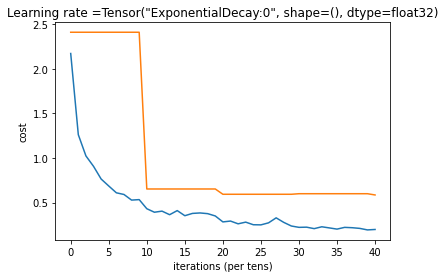

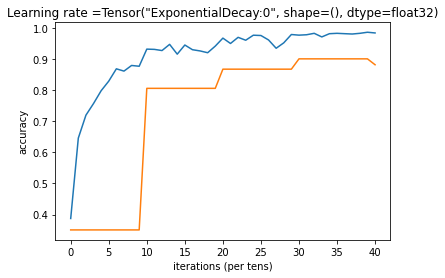

Parameters have been trained!


In [14]:
GCN_points = scipy.io.loadmat('Labeled_Cuprite_Data/data_points.mat')['data_points']
GCN_points = normalize(GCN_points)

CNN_points = scipy.io.loadmat('Labeled_Cuprite_Data/data_points_CNN.mat')['data_points']
CNN_points = normalize(CNN_points)

Labels = scipy.io.loadmat('Labeled_Cuprite_Data/labels.mat')['labels']
Labels = Labels.T
num_classes = 12
Labels_onehot = tf.keras.utils.to_categorical(Labels, num_classes)

# cuprite_train, cuprite_test, cnn_train, cnn_test, labels_train, labels_test
Train_X, Test_X, X_train, X_test,TrLabel, TeLabel=split_data(GCN_points, CNN_points, Labels_onehot)


print(Train_X.shape)
print(Test_X.shape)

Train_L = adjacency_matrix(Train_X) 
Train_L = Train_L.astype(int)
Train_L = Train_L.todense() 

Test_L = adjacency_matrix(Test_X) 
Test_L = Test_L.astype(int)
Test_L = Test_L.todense() 
 


parameters, val_acc, features = train_mynetwork(Train_X, Test_X, X_train, X_test, TrLabel, TeLabel, Train_L, Test_L) 